In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import os
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary,alpha="auto",eval_every=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/menis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/menis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/menis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores


In [3]:
data = data[data["is_retweet"] == False]

data.rename(index=str, columns={"year": "date_year"},inplace=True)
data.rename(index=str, columns={"month": "date_month"},inplace=True)

data.drop(["hour","in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,date_month,date_year,week_year,labels,vaderScore
favorite_count,1.000000,0.891237,-0.164023,0.185635,-0.164811,0.076417,-0.098971
retweet_count,0.891237,1.000000,-0.089613,0.144045,-0.090638,0.090506,-0.166127
date_month,-0.164023,-0.089613,1.000000,-0.302847,0.984279,-0.032168,0.064430
date_year,0.185635,0.144045,-0.302847,1.000000,-0.302369,0.021680,-0.019233
week_year,-0.164811,-0.090638,0.984279,-0.302369,1.000000,-0.034066,0.066510
labels,0.076417,0.090506,-0.032168,0.021680,-0.034066,1.000000,-0.129911
vaderScore,-0.098971,-0.166127,0.064430,-0.019233,0.066510,-0.129911,1.000000


In [4]:
taggedDescriptions = []
for idx, row in data.iterrows():
    desc = row["noTags_punct"]
    tokens = word_tokenize(desc)
    tagged = pos_tag(tokens)
    taggedDescriptions.append(tagged)
taggedDescriptions

[[('to', 'TO'),
  ('all', 'DT'),
  ('americans', 'NNS'),
  ('many', 'JJ'),
  ('blessings', 'NNS'),
  ('to', 'TO'),
  ('you', 'PRP'),
  ('all', 'DT'),
  ('looking', 'VBG'),
  ('forward', 'RB'),
  ('to', 'TO'),
  ('a', 'DT'),
  ('wonderful', 'JJ'),
  ('prosperous', 'JJ'),
  ('2017', 'CD'),
  ('as', 'IN'),
  ('we', 'PRP')],
 [('well', 'RB'),
  ('the', 'DT'),
  ('new', 'JJ'),
  ('year', 'NN'),
  ('begins', 'VBZ'),
  ('we', 'PRP'),
  ('will', 'MD'),
  ('together', 'RB'),
  ('make', 'VB'),
  ('america', 'NN'),
  ('great', 'JJ'),
  ('again', 'RB')],
 [('chicago', 'JJ'),
  ('murder', 'NN'),
  ('rate', 'NN'),
  ('is', 'VBZ'),
  ('record', 'NN'),
  ('setting', 'VBG'),
  ('4331', 'CD'),
  ('shooting', 'VBG'),
  ('victims', 'NNS'),
  ('with', 'IN'),
  ('762', 'CD'),
  ('murders', 'NNS'),
  ('in', 'IN'),
  ('2016', 'CD'),
  ('if', 'IN'),
  ('mayor', 'NN'),
  ('cant', 'NN'),
  ('do', 'VB'),
  ('it', 'PRP'),
  ('he', 'PRP'),
  ('must', 'MD'),
  ('ask', 'VB'),
  ('for', 'IN'),
  ('federal', 'JJ'),
  (

In [5]:
descriptions = []
for item in taggedDescriptions:
    processed = ""
    for el in item:
        if el[1].startswith("N"): #or el[1].startswith("J"):  #se iniziano con N o J sono nomi o aggettivi, quello che ci serve di più
            processed = processed + " " + el[0]
    descriptions.append(processed)

In [6]:
data["n_j"] = descriptions

In [7]:
majorCluster = 4
d1 = data[data["labels"] == majorCluster ]


#stemmed_words = pd.Series(' '.join(d1['modded1_stemmed']).split()).value_counts()
stemmed_words = pd.Series(' '.join(d1["n_j"]).split()).value_counts()
#print(stemmed_words)

stemmed_words = stemmed_words[3:]
stemmed_words = stemmed_words[stemmed_words > 2]
#d1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))
d1["n_j"] = d1["n_j"].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [8]:
print(stemmed_words)


border         57
wall           51
news           49
tax            47
house          46
deal           45
president      43
security       43
states         42
time           41
today          40
democrats      40
years          39
korea          39
state          39
trade          34
crime          33
day            31
china          30
republicans    29
media          28
jobs           27
way            27
cuts           26
job            26
healthcare     24
s              24
world          23
dems           23
meeting        22
               ..
base            3
judge           3
dinner          3
virginia        3
venezuela       3
va              3
topics          3
fed             3
ohr             3
citizens        3
alabama         3
gillum          3
jerome          3
nafta           3
respect         3
call            3
cities          3
areas           3
bush            3
building        3
television      3
brave           3
coverage        3
otto            3
missile   

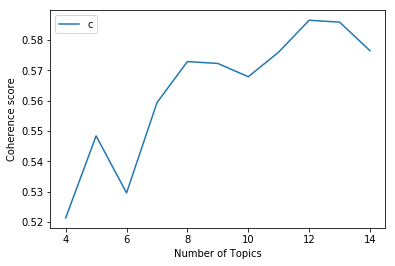

12


In [9]:
from gensim.corpora.dictionary import Dictionary

tokenizer = RegexpTokenizer(r'\w+')

#corpus = d1["m"].tolist()
corpus = d1["n_j"].tolist()
#print(len(corpus))
corp = []
for string in corpus:
    tokens = tokenizer.tokenize(string)
    corp.append(tokens)

common_dictionary = Dictionary(corp)
common_corpus = [common_dictionary.doc2bow(text) for text in corp]
tfidf = TfidfModel(common_corpus)
tfidf_corpus = tfidf[common_corpus]

start,stop,step=4,15,1
nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)

print(nTopics)


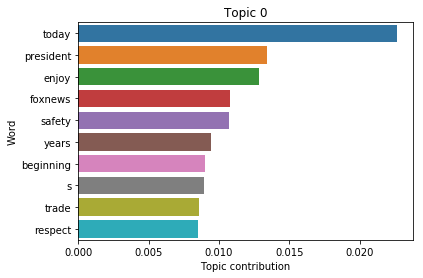

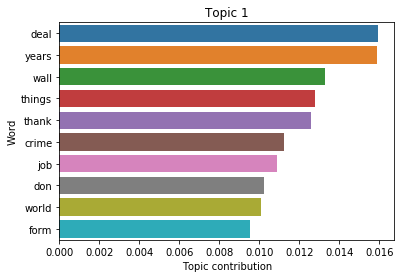

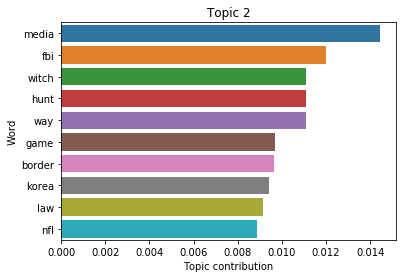

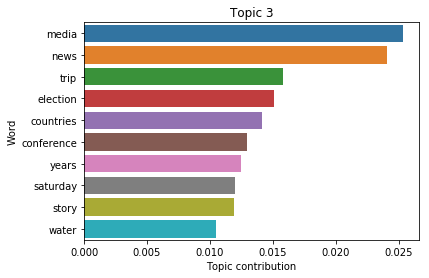

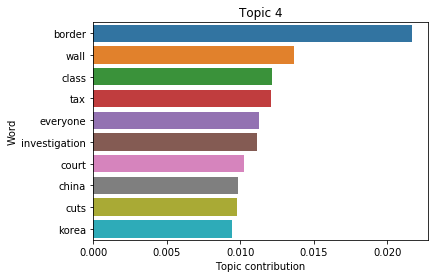

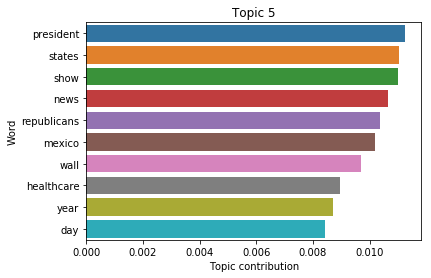

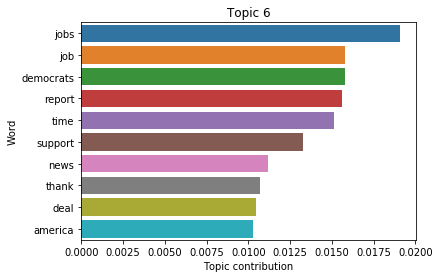

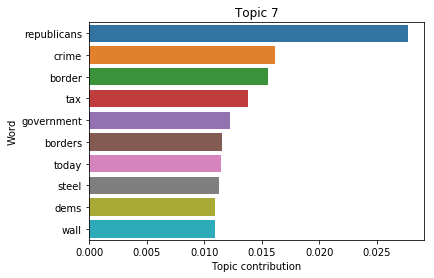

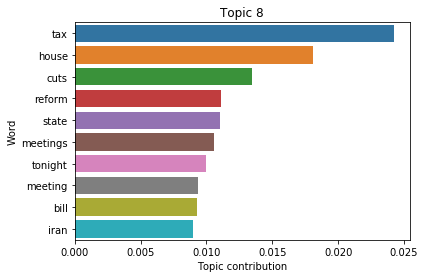

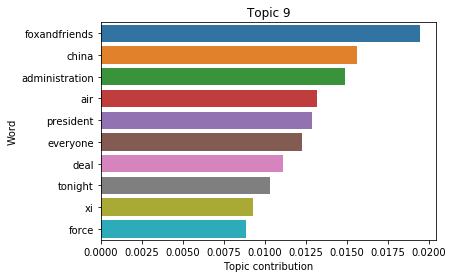

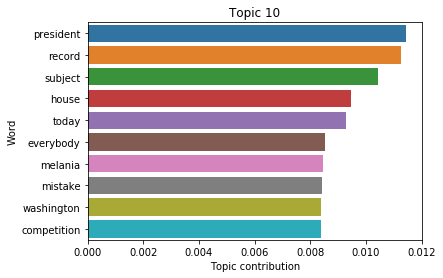

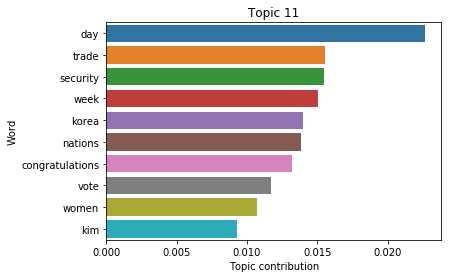

776 776
topics_count [77, 75, 72, 68, 67, 65, 63, 62, 60, 60, 55, 52]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
#nTopics = 5

lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary,alpha="auto",eval_every=5)

topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)
#print(g)
topicFigures = []
for topic in topics:
    words = []
    weights = []
    for word in topic[1]:
        if abs(word[1]) > 0.001:
            words.append(word[0])
            #prendi valore assoluto perchè positivo/negativo non ha senso 
            weights.append(abs(word[1]))
    labels = words
    sizes = weights
    fig = plt.figure()
    plt.title("Topic " + str(topic[0]),figure=fig)
    sns.barplot(x=weights, y=words,figure=fig)
    plt.xlabel("Topic contribution",figure=fig)
    plt.ylabel("Word",figure=fig)
    plt.show()     
    topicFigures.append(fig)
topicColumn = []
topicList = {}

for el in tfidf_corpus:
    vector = lda.get_document_topics(el)
    #get topic
    m = max(y for (x,y) in vector)
    ind = [x for x, y in enumerate(vector) if y[1] == m][0]
    #print(ind,m)
    if ind not in topicList:
        topicList[ind] = 1
    else: 
        topicList[ind] += 1
    topicColumn.append(ind)

print(len(topicColumn),len(d1))
d1["topic"] = topicColumn
#print(topicColumn)
print("topics_count",d1["topic"].value_counts().tolist())


In [11]:
topics

[(0,
  [('today', 0.022647405),
   ('president', 0.013439747),
   ('enjoy', 0.012875353),
   ('foxnews', 0.010784987),
   ('safety', 0.010680811),
   ('years', 0.00943624),
   ('beginning', 0.00900149),
   ('s', 0.008916999),
   ('trade', 0.008611343),
   ('respect', 0.008492391)]),
 (1,
  [('deal', 0.015937202),
   ('years', 0.015900843),
   ('wall', 0.0132716745),
   ('things', 0.012777289),
   ('thank', 0.012576634),
   ('crime', 0.011218592),
   ('job', 0.010888701),
   ('don', 0.010251772),
   ('world', 0.010074277),
   ('form', 0.009524185)]),
 (2,
  [('media', 0.014444906),
   ('fbi', 0.011999699),
   ('witch', 0.011111662),
   ('hunt', 0.011111343),
   ('way', 0.011074691),
   ('game', 0.0097048795),
   ('border', 0.009625833),
   ('korea', 0.00939405),
   ('law', 0.009149586),
   ('nfl', 0.008872565)]),
 (3,
  [('media', 0.025320278),
   ('news', 0.024023153),
   ('trip', 0.01577399),
   ('election', 0.015107832),
   ('countries', 0.014160107),
   ('conference', 0.012977364),


el = tfidf_corpus[0]
v = lda.get_document_topics(el)
topics = [x for (x,y) in v]
print(topics)
docs = []
i = 0
for el in tfidf_corpus:
    v = lda.get_document_topics(el)
    weights = [y for (x,y) in v]
    docs.append(weights)
    i =+ 1
docs

docs = np.array(docs)
docs.shape
plt.pcolor(docs, norm=None, cmap='Blues')
plt.yticks(np.arange(docs.shape[0])+0.5, [x for x in range(0,len(tfidf_corpus))]);
plt.xticks(np.arange(docs.shape[1])+0.5, topics);
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  
#corpus = d1["m"].tolist()
corpus = d1["n_j"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

d1.reset_index(inplace=True,drop=True)
res = pd.concat([d1,c], axis=1)
#res1 = res.drop(["m","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)
res1 = res.drop(["n_j","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)

dataWithText = res.drop(["week_year","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
#dataWithText = res
res1.columns

In [ ]:
plt.hist(res1["topic"])

In [ ]:
sil = []
for c in range(2,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

In [ ]:
#res1 = res.drop(["week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
res1 = res.drop(["n_j","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)
dataWithText = res.drop(["week_year","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 


In [ ]:
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=7) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

In [ ]:
res1["labels"] = labels
dataWithText["labels"] = labels


In [ ]:
for cluster in res1["labels"].unique():
    g1 = res1[res1["labels"] == cluster]

   # temp = dataWithText[dataWithText["labels"] == cluster]


    #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    print("CLUSTER " + str(cluster))
    print(len(g1))
    print(g1["date_year"].value_counts())
    print(g1["date_year"].unique().tolist())
    print("anni nel cluster ", len(g1["date_year"].unique().tolist()))
    #print(temp["week_year"].unique().tolist())
   # print("numero di settimane in cluster", len(temp["week_year"].unique().tolist()))

    #plt.hist(g1["topic"],bins=[0,1,2,3,4,5,6,7,8,9,10])
    #plt.title("topicdistrib in cluster " + str(cluster))
    #plt.show()
    
    #plot bar chart with topics
    counts = g1["topic"].value_counts()
    arr = [0 for x in range(0,nTopics)]
    topicStrings = []
    for i in range(0,len(arr)):
        if i in counts:
            arr[i] = counts[i]
            topicStr = ""
            for el in topics[i][1]:
                topicStr += " " + el[0] 
            topicStrings.append([i,topicStr])
    ind = [i for i in range(0,nTopics)]    
    plt.bar(ind,arr)
    plt.title("Topics in cluster " + str(cluster))
    plt.xticks(np.arange(0, nTopics, step=1))
    plt.xlabel("Topics")
    plt.ylabel("Frequency")
    plt.show()
    
    for el in topicStrings:
        print("Topic " + str(el[0]) + ": " + el[1])

    
    g1.pivot(columns='topic').vaderScore.plot(kind = 'hist',alpha=0.6,stacked=True,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
    plt.title("Vader score in cluster " + str(cluster) )
    plt.xlabel("Vader score")
    plt.show()
